<a id="up"></a>

# Description du Notebook
---------------
**Objectif** : Séparer les données de taille en créant des groupes selon des intervalles d'âge.

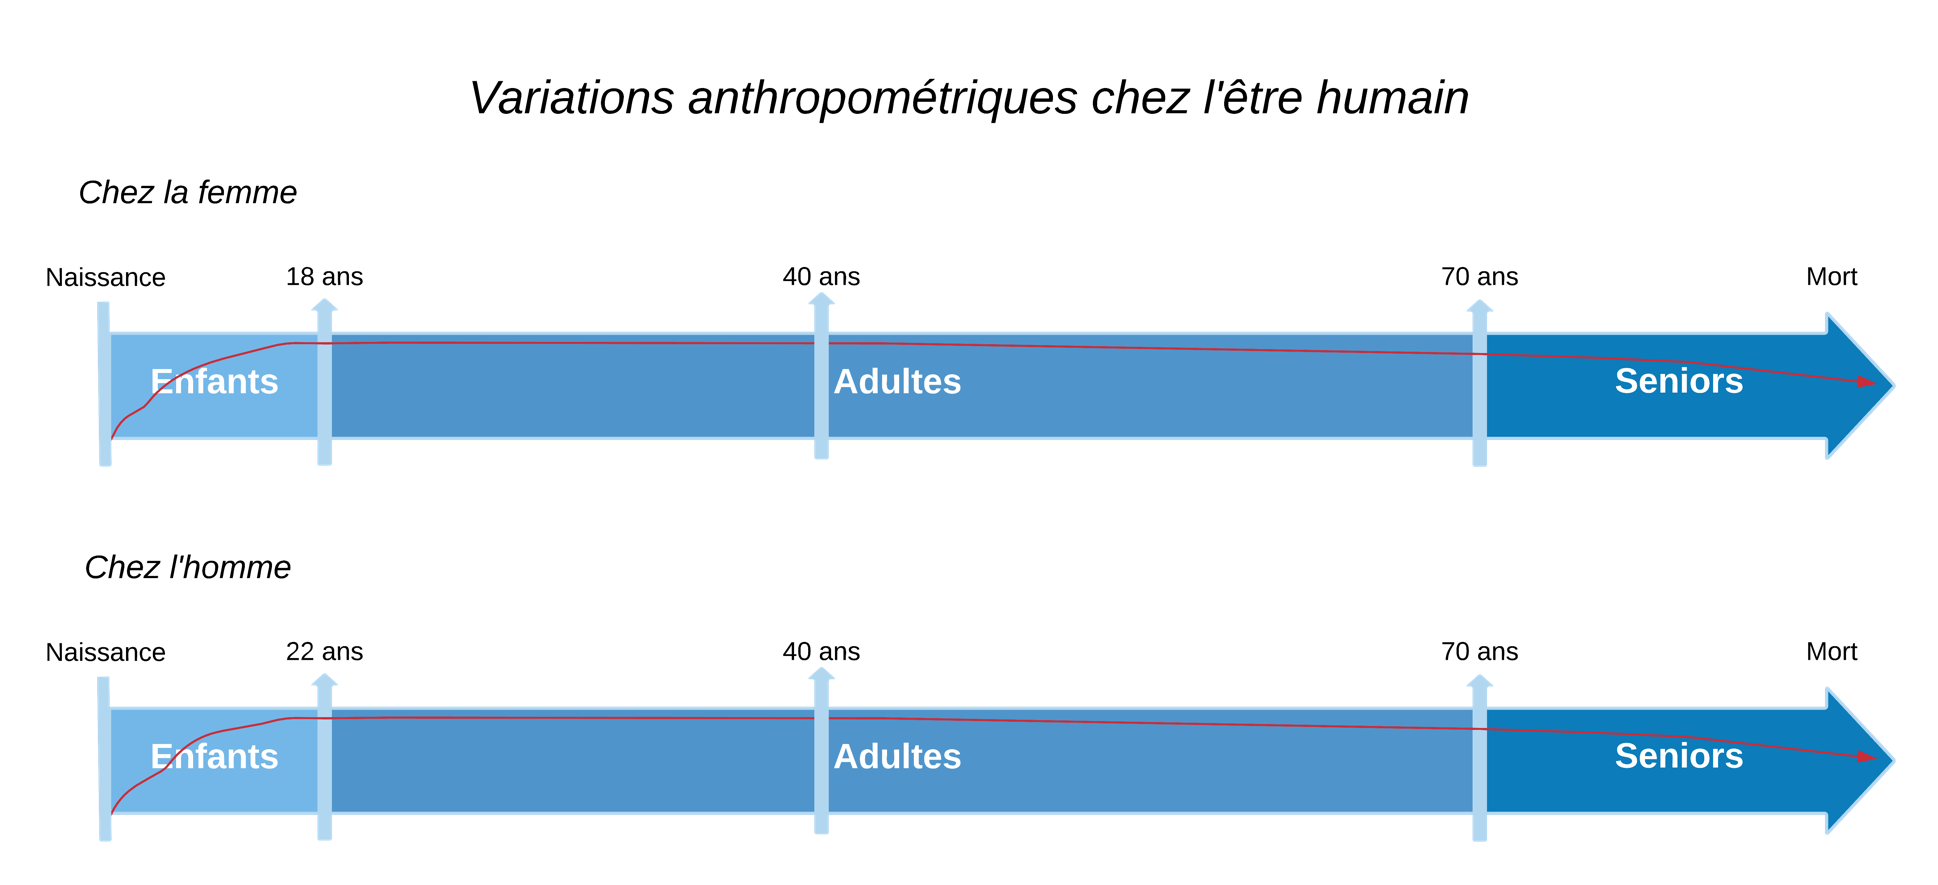

**Visualisation des données** : Boxplots, Kernel Density Estimation plots

## Sommaire [(^)](#up)
-----------
- [Import des données et des packages](#import)
- [Intervalles Âge](#interval-age)
- [Boxplots : Taille du patient ~ Tranche d'Âge](#boxplot)
- [Kernel Density Estimation plots](#kde)
- [KDE : Interprétation des résultats](#kde-interpretation)
- [Probability Plots](#probplots)
- [À faire](#to-do)

<a id="import"></a>

## Import des données et des packages [(^)](#up)
----------

In [4]:
import pandas as pd
import os
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity

start = timeit.default_timer()

# Load data
# LOX-PC : file = os.path.join('C:/Users/LOX/Desktop/CLB/test/Taille', 'mean_std_v2.csv')
# LOX-Mac : file = os.path.join('/Users/loicdancelme/Desktop/Stage_TIS5/test', 'mean_std_v2.csv')
# CLB-PC : file = os.path.join('C:/Users/dancel/Desktop/DQA/Projet Centrale/Taille', 'mean_std_v2.csv')
data = pd.read_csv('mean_std_v2.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')

<a id="interval-age"></a>

## Intervalles Âge [(^)](#up)
-------------

In [5]:
# Taille : m -> cm
data["Taille"] = data["Taille"] *100

# //// Intervalles Age
age20 = list(range(20 *365)) # Croissance ~ de 0 à 20 ans
age20_40 = list(range((20 *365), (40 *365))) # Stagnation de 0 à 40 ans 
age40_70 = list(range((40 *365), (70 *365))) # Diminution taille à partir de 40 ans
age70plus = list(range((70 *365) , (110 *365)))

# //// Separation en groupe selon les intervalles d'age
data20 = data[data['age_at_entry'].isin(age20)]
data20.to_csv("data20.csv", index=False)
data20_40 = data[data['age_at_entry'].isin(age20_40)]
data40_70 = data[data['age_at_entry'].isin(age40_70)]
data70 = data[data['age_at_entry'].isin(age70plus)]

m20, s20 = stats.norm.fit(data20['Taille'])
m20_40, s20_40 = stats.norm.fit(data20_40['Taille'])
m40_70, s40_70 = stats.norm.fit(data40_70['Taille'])
m70, s70 = stats.norm.fit(data70['Taille'])

# //// Groups stats: mean, std
groups_mean = [m20, m20_40, m40_70, m70]
groups_std = [s20, s20_40, s40_70, s70]

Distribution des patients dans les différents groupes

|Période|Intervalle (ans)|Effectif| Moyenne | Ecart-type|
|:-|:-:|:-:|:-:|:-:|
|Enfant / Adolescent|[0-20]|105239|128.51|32.75|
|Jeune Adulte|[20-40]|35848|170.23|9.92|
|Adulte|[40-70]|229963|167.53|8.93|
|Seniors|[70-110]|76693|165.48|9.02|

**Total** : 447 743 lignes.

Quelques *outliers* se remarquent :

In [6]:
# //// Some weird values
data_outliers00 = data[data['age_at_entry'] < 0] # age < 0
data_outliers01 = data[data['Taille'] > 220]     # Taille > 2.5 m


print('Outliers : age < 0, n = 11, 5 premières valeurs :\n')
print(data_outliers00.iloc[:5, [1, 4, -2]])
print('\nOutliers : Taille > 250, n = 13, 5 premières valeurs :\n')
print(data_outliers01.iloc[:5, [1, 4, -2]])

Outliers : age < 0, n = 11, 5 premières valeurs :

        age_at_entry  Taille      mean
33460         -16945   163.0  1.614615
34467         -16191   180.0  1.800000
190905          -177    66.0  1.398636
236976          -366    50.0  0.926222
272814          -109    72.0  1.225244

Outliers : Taille > 250, n = 13, 5 premières valeurs :

        age_at_entry  Taille      mean
45802          24759   250.0  2.500000
134112          9506   240.0  1.566789
188154          2198   870.0  1.720000
190938          5386   490.0  1.398636
245257           670   480.0  0.974255


<a id="boxplot"></a>

## Boxplots : Taille du patient ~ Tranche d'Âge [(^)](#up)
----------------



Text(0.5, 1.0, "Taille du patient ~ Tranche d'Âge")

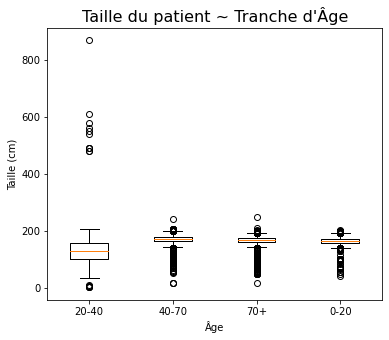

In [7]:
# Data used for the boxplpots
plt.figure(figsize=(6, 5))
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
labels={'0-20', '70+', '40-70', '20-40'}

# boxplot w/o ylim (outliers are visible)
plt.boxplot(data_bxplt, labels=labels)
plt.ylabel("Taille (cm)")
plt.xlabel("Âge")
plt.title("Taille du patient ~ Tranche d'Âge", fontsize=16)

On recommence en supprimant les valeurs de taille > 300 cm

Text(0.5, 1.0, 'Boxplot sans les outliers')

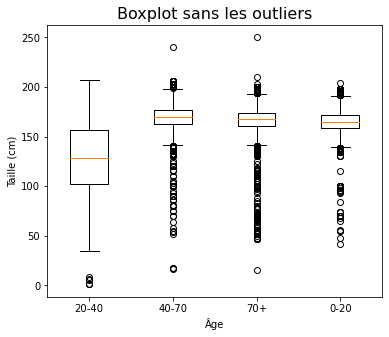

In [8]:
# boxplot w/o outliers
data20 = data20[data20["Taille"] < 300]
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
plt.figure(figsize=(6, 5))
plt.boxplot(data_bxplt, labels=labels)
plt.xlabel("Âge")
plt.ylabel("Taille (cm)")
plt.title("Boxplot sans les outliers", fontsize=16)

<a id="kde"></a>

## Kernel Density Estimation plots [(^)](#up)
------------

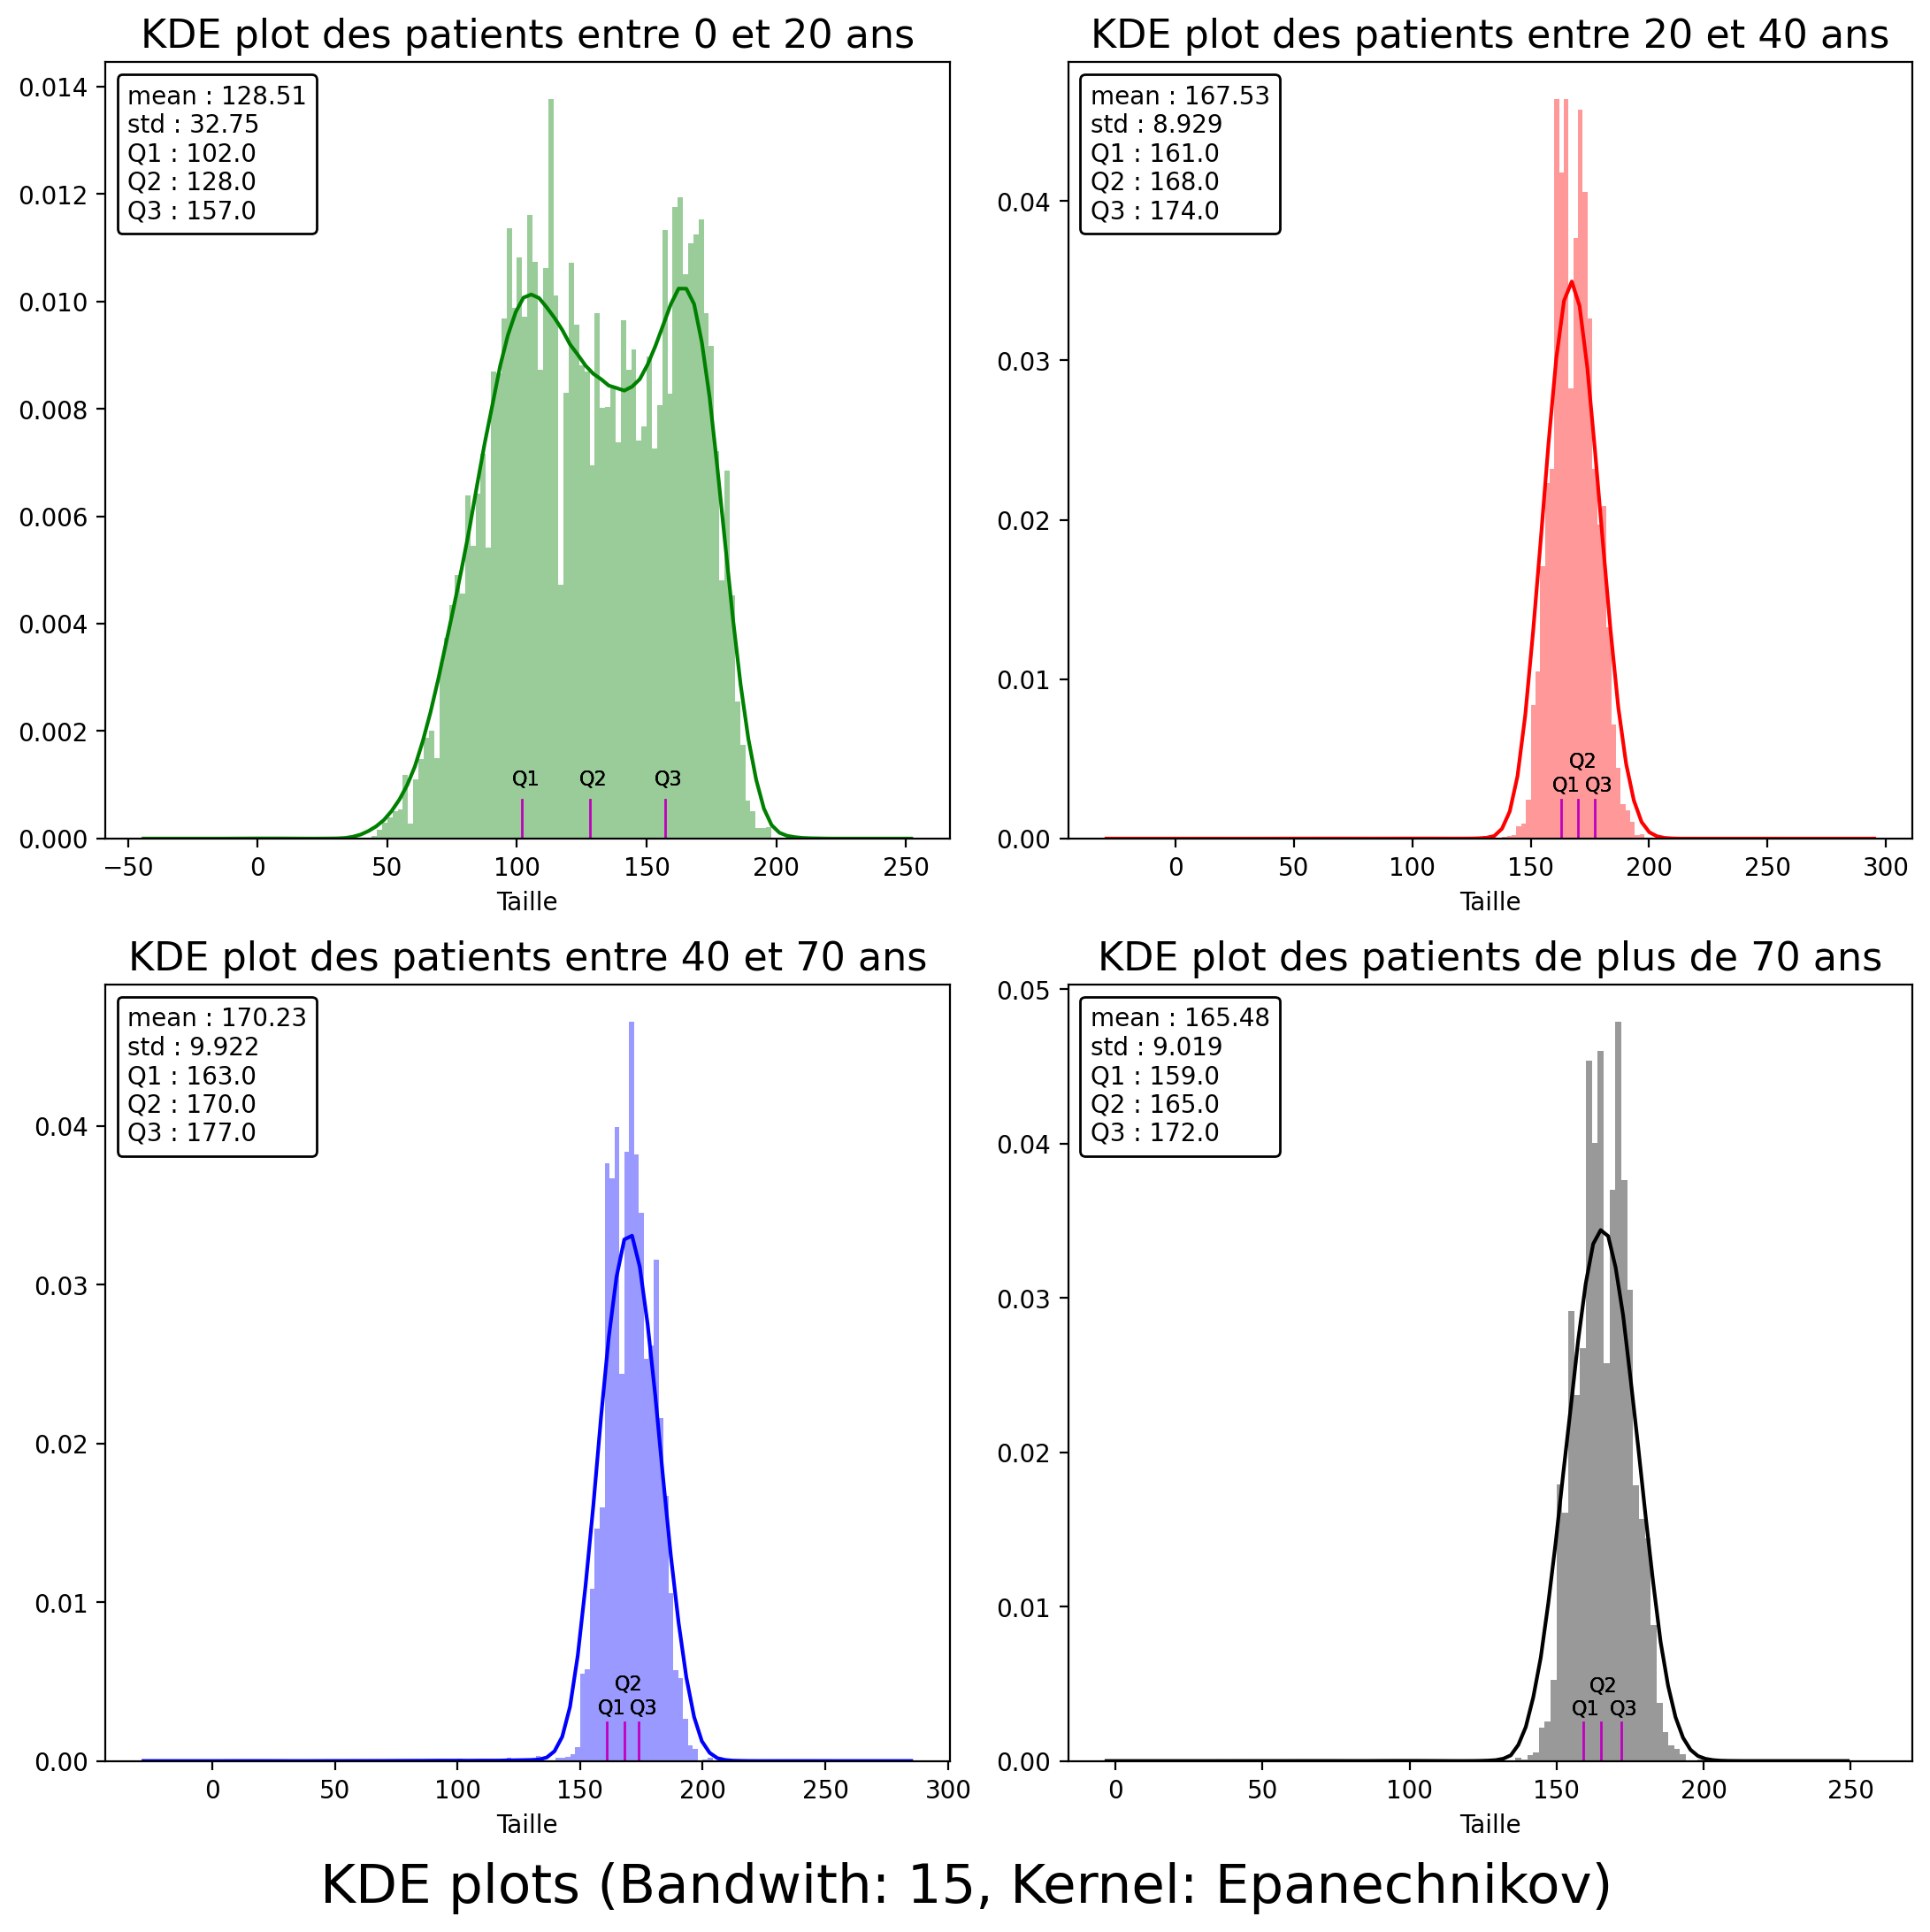

In [9]:
# plot a kernel density estimation over a stacked barchart
fig, axes = plt.subplots(2, 2, figsize=[11, 11], dpi=200)

# Affichage quantiles
iqr20 = stats.mstats.mquantiles(data20['Taille'])
iqr20_40 = stats.mstats.mquantiles(data20_40['Taille'])
iqr40_70 = stats.mstats.mquantiles(data40_70['Taille'])
iqr70 = stats.mstats.mquantiles(data70['Taille'])
iqrs = [iqr20, iqr20_40, iqr40_70, iqr70]

def iqr_plot(iqr, ax, y, y2):
    for xc in iqr:
        ax.axvline(x=xc, ymin= 0, ymax = 0.05, c ='m', linewidth = 1)
    for i in iqr:
        ax.text(iqr[0]-4, y,'Q1', fontsize = 8)
        ax.text(iqr[1]-4, y2,'Q2', fontsize = 8)
        ax.text(iqr[2]-4, y,'Q3', fontsize = 8)

# Labels def
def lbl_box(i):
    lbl = "mean : " + str(round(groups_mean[i],2)) + "\nstd : " + str(round(groups_std[i],3)) + "\nQ1 : "  
    lbl += str(iqrs[i][0]) + "\nQ2 : "  + str(iqrs[i][1]) + "\nQ3 : "  + str(iqrs[i][2])
    return lbl
                                                                      
lbl20 = lbl_box(0)
lbl20_40 = lbl_box(1)
lbl40_70 = lbl_box(2)
lbl70 = lbl_box(3)

# Display mean, std, IQR
def mean_std_box(lbl, x, y):
    at = AnchoredText(lbl,
              prop=dict(size=10), frameon=True,
              loc='upper left',
              )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[x][y].add_artist(at)


# //// [00-20] range Kernel 
sns.distplot(data20['Taille'], bins= np.arange(0,220,2), norm_hist = False, color="g", ax=axes[0, 0], kde_kws={"bw":15, "kernel":"epa"})
iqr_plot(iqr20, axes[0][0], 0.001, 0.001)
axes[0][0].set_title('KDE plot des patients entre 0 et 20 ans', fontsize=16)
mean_std_box(lbl20, 0, 0)

# //// [20-40] range histogram
sns.distplot(data20_40['Taille'], bins= np.arange(70,260,2), color="b", ax=axes[1, 0], kde_kws={"bw":15, "kernel":"epa"})
iqr_plot(iqr20_40, axes[0][1], 0.003, 0.0045)
axes[0][1].set_title('KDE plot des patients entre 20 et 40 ans', fontsize=16)
mean_std_box(lbl20_40, 1, 0)

# //// [40-70] range histogram
sns.distplot(data40_70['Taille'], bins= np.arange(70,260,2), color="r", ax=axes[0, 1], kde_kws={"bw":15, "kernel":"epa"})
iqr_plot(iqr40_70, axes[1][0], 0.003, 0.0045)
axes[1][0].set_title('KDE plot des patients entre 40 et 70 ans', fontsize=16)
mean_std_box(lbl40_70, 0, 1)

# //// [70-110] range histogram
sns.distplot(data70['Taille'], bins= np.arange(70,260,2), color="k", ax=axes[1, 1], kde_kws={"bw":15, "kernel":"epa"})
iqr_plot(iqr70, axes[1][1], 0.003, 0.0045)
axes[1][1].set_title('KDE plot des patients de plus de 70 ans', fontsize=16)
mean_std_box(lbl70, 1, 1)

plt.suptitle("KDE plots (Bandwith: 15, Kernel: Epanechnikov)", fontsize = 22, y = 0)
plt.tight_layout(pad=1)

<a id="kde-interpretation"></a>

## KDE : Interprétation des résultats [(^)](#up)
--------------
### • Définition
(Source [Wikipédia:Estimation_par_noyau](https://fr.wikipedia.org/wiki/Estimation_par_noyau))

Le *Kernel Density Estimation* est une technique d'estimation de la densité de probabilité d'une variable aléatoire.

Si $x_{1}, x_{2}, ..., x_{N} \sim f$ est un échantillon i.i.d. d'une variable aléatoire, alors l'estimateur non-paramétrique par la méthode du noyau de la densité est :

$$\hat{f_{h}}(x) = \frac{1}{Nh}\sum_{i=1}^{N}K(\frac{x-x_{i}}{h})$$

où K est un noyau (*kernel en anglais*) et h un paramètre nommé fenêtre, qui régit le degré de lissage de l'estimation. Bien souvent, K est choisi comme la densité d'une fonction gaussienne standard (espérance nulle et variance unitaire) :

$$K(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$$

### • Interprétation des courbes

L'aspect des courbes calculées par la fonction *KDE* nous laisse penser que le groupe des 'enfants' (<20 ans) a une distribution bimodale.

> "In biology five factors are known to contribute to bimodal distributions of population sizes : the initial distribution of individual sizes, the distribution of growth rates among the individuals, the size and time dependence of the growth rate of each individual" ([Wiki](https://en.wikipedia.org/wiki/Multimodal_distribution#Biology))

Pour les autres groupes la fonction *KDE* résulte en une distribution unimodale qui s'apparente de très près à celle d'une loi normale.

<a id="probplots"></a>

## Probability Plots [(^)](#up)

Text(0.5, 0.96, 'Probability Plots')

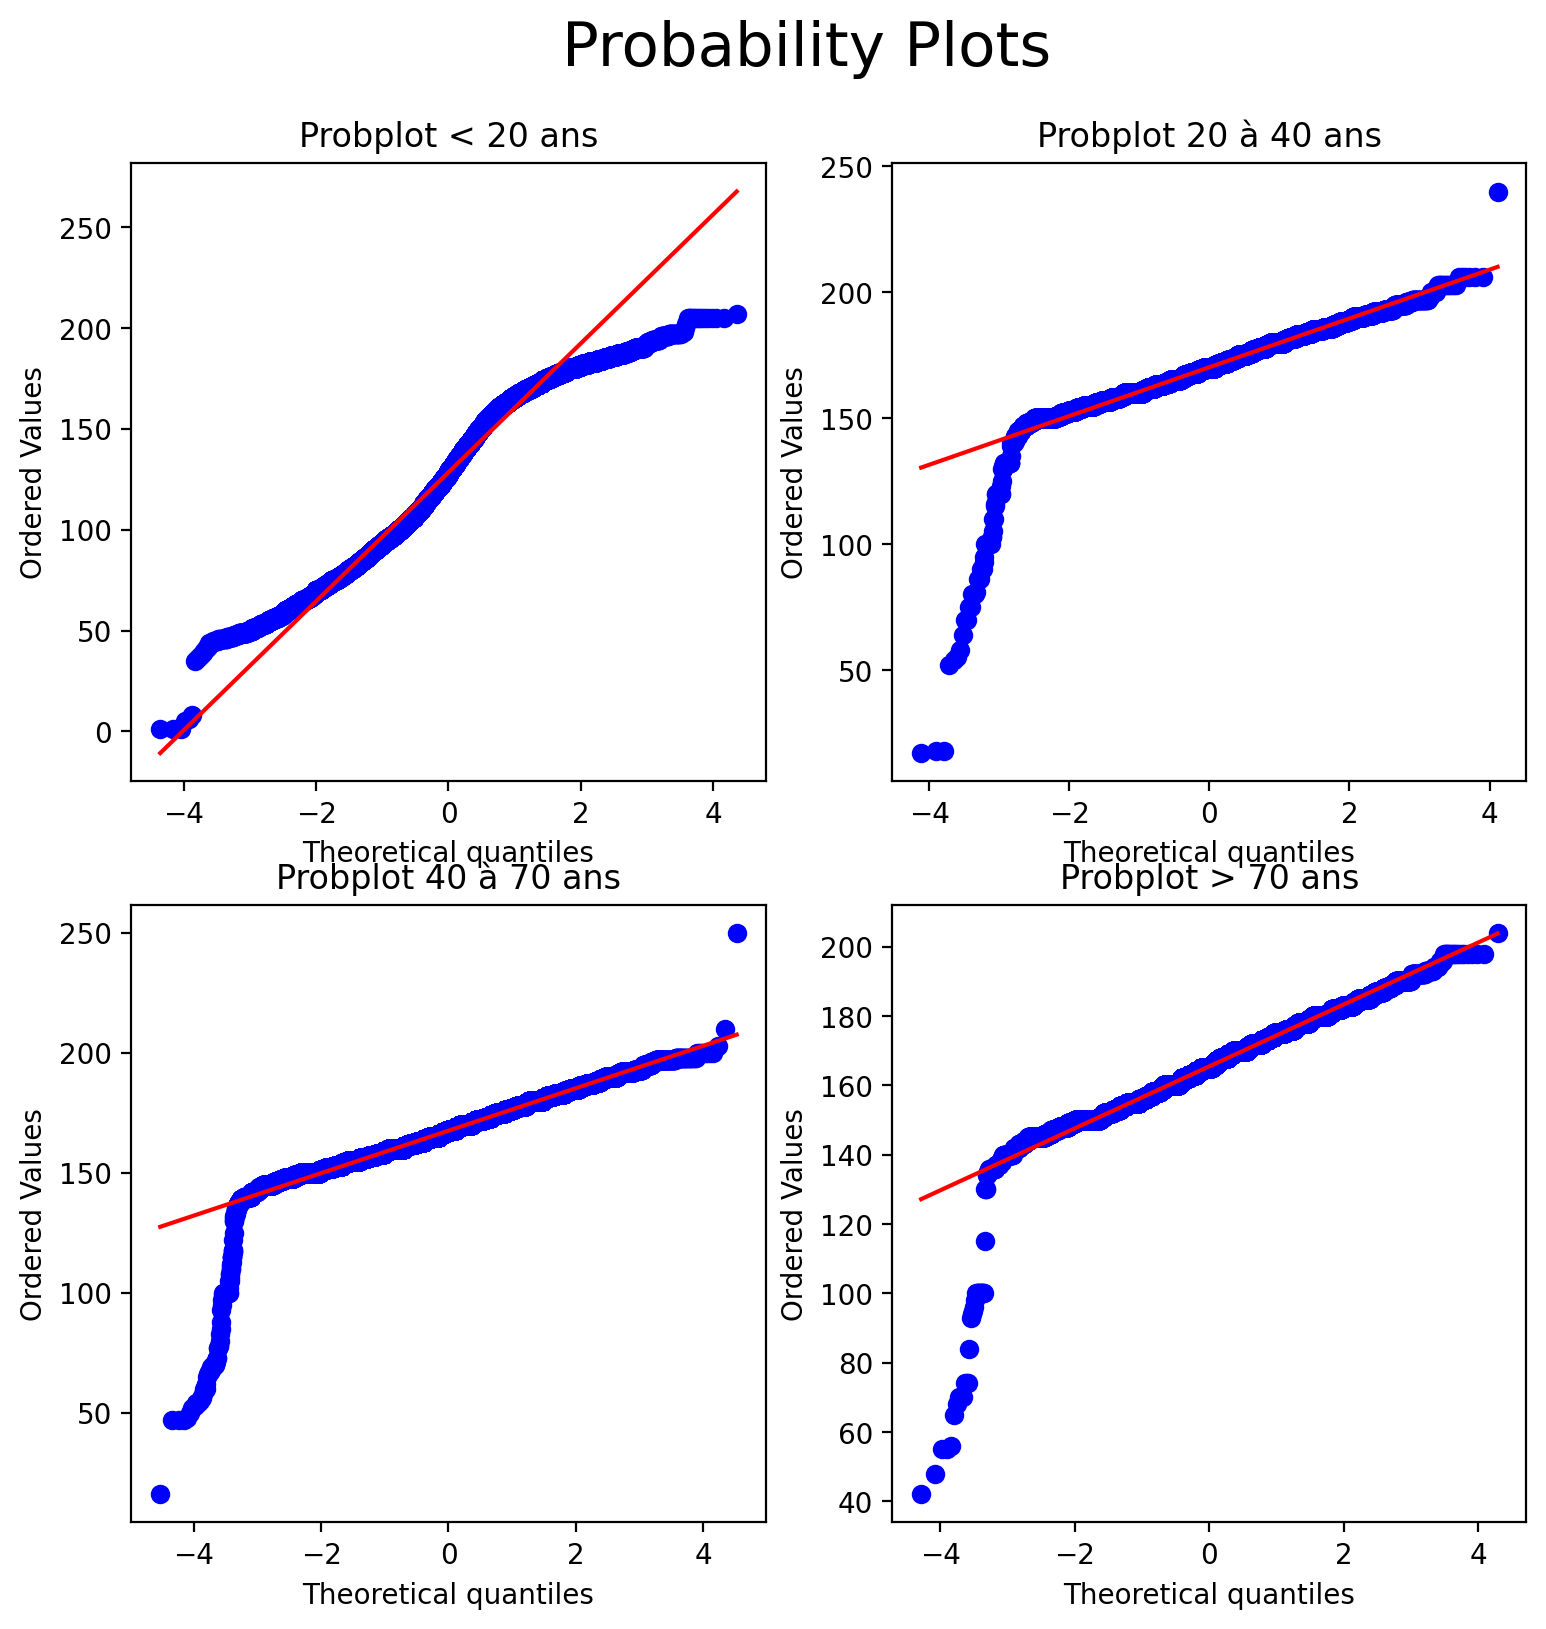

In [10]:
fig, axes = plt.subplots(2, 2, figsize=[9, 9], dpi=200)
stats.probplot(data20['Taille'], dist="norm", plot=axes[0][0])
axes[0][0].set_title('Probplot < 20 ans')

stats.probplot(data20_40['Taille'], dist="norm", plot=axes[0][1])
axes[0][1].set_title('Probplot 20 à 40 ans')

stats.probplot(data40_70['Taille'], dist="norm", plot=axes[1][0])
axes[1][0].set_title('Probplot 40 à 70 ans')

stats.probplot(data70['Taille'], dist="norm", plot=axes[1][1])
axes[1][1].set_title('Probplot > 70 ans')

plt.suptitle("Probability Plots", fontsize = 22, y=0.96)


#### With Probscale Package *([Doc](https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html) Matplotlib)*

NameError: name 'probscale' is not defined

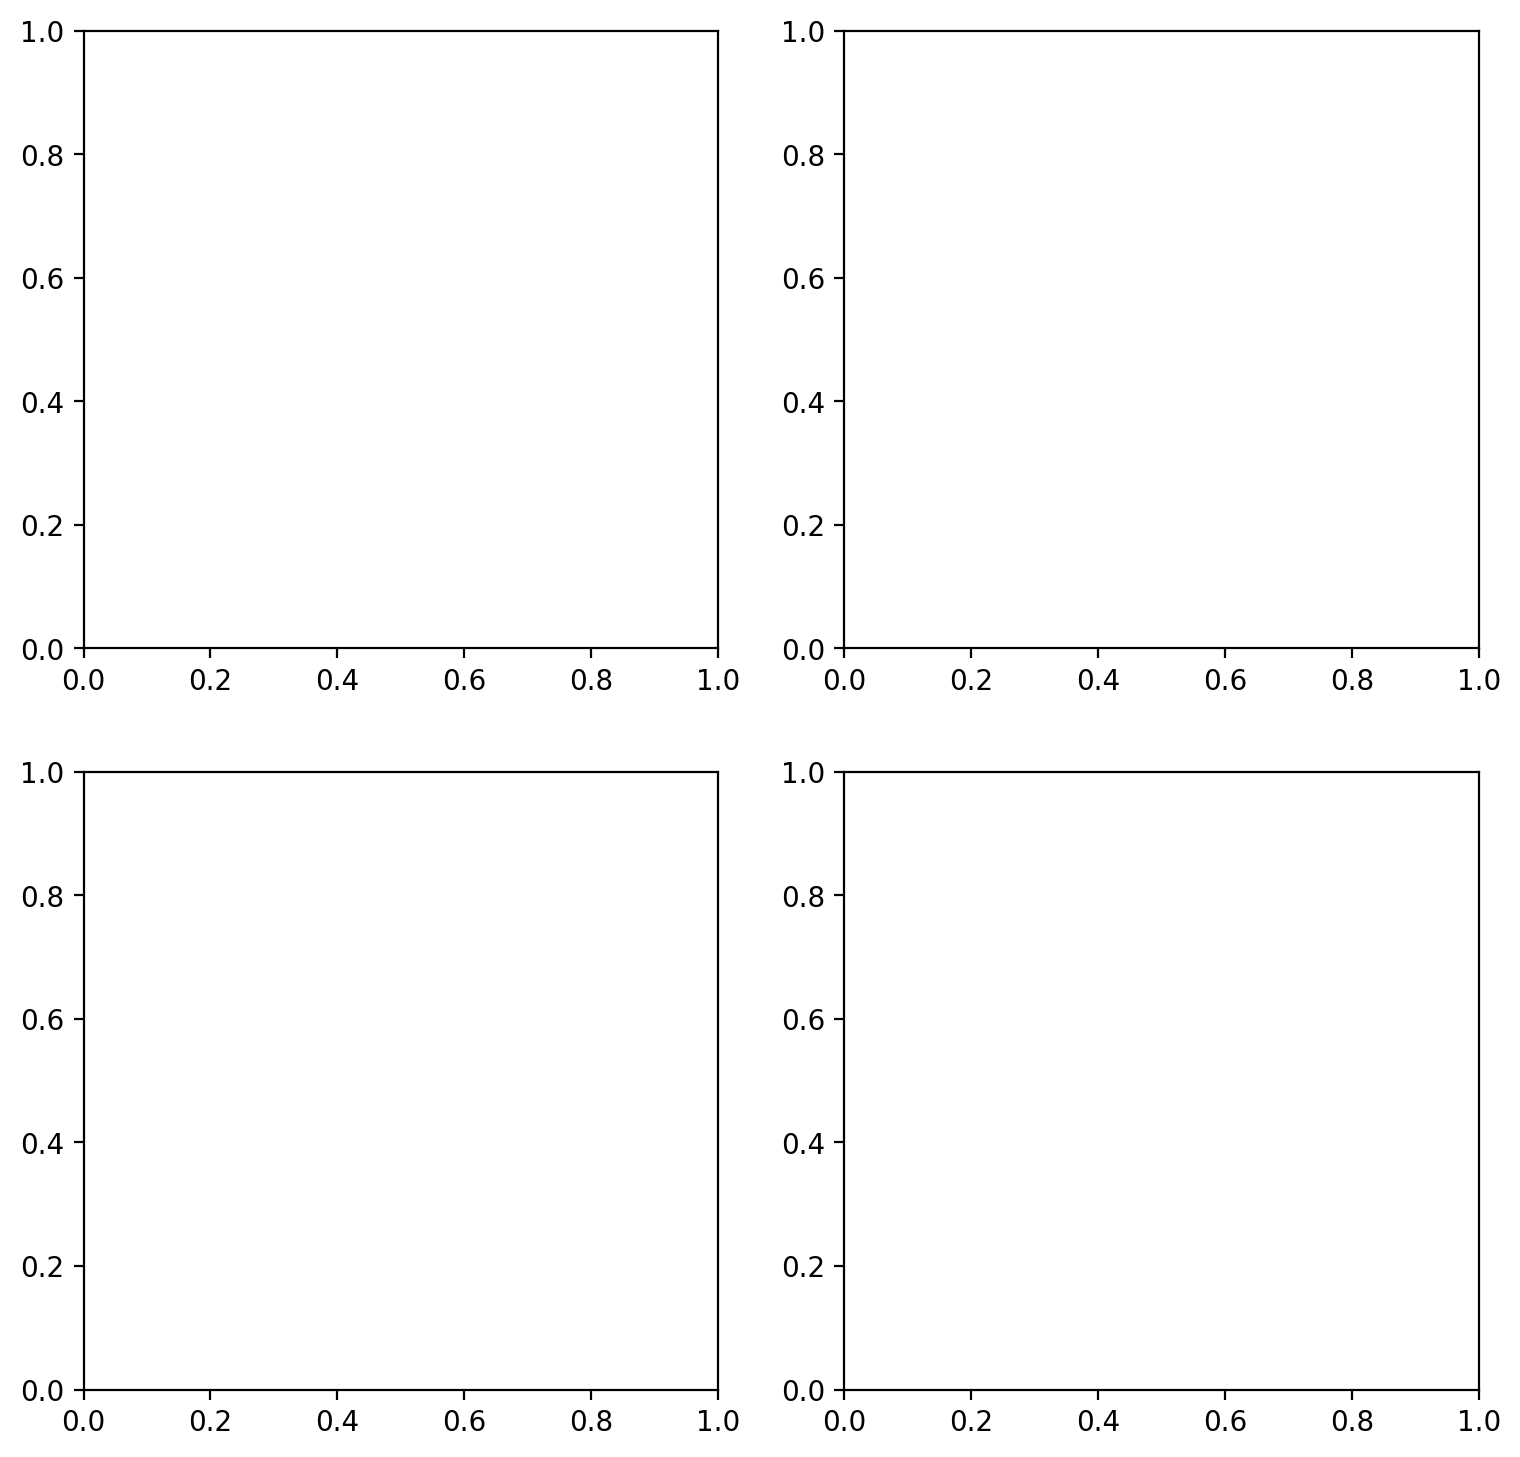

In [11]:
fig, axes = plt.subplots(2, 2, figsize=[9, 9], dpi=200)
probscale.probplot(data20['Taille'], ax=axes[0][0], plottype='pp', bestfit=True,
                   problabel='Percentile', datalabel='Taille (cm)',
                   line_kws=dict(label='Best-fit line'))
axes[0][0].set_title('Probplot < 20 ans')

probscale.probplot(data20_40['Taille'], ax=axes[0][1], plottype='pp', bestfit=True,
                   problabel='Percentile', datalabel='Taille (cm)',
                   line_kws=dict(label='Best-fit line'))
axes[1][0].set_title('Probplot 20 à 40 ans')

probscale.probplot(data40_70['Taille'], ax=axes[1][0], plottype='pp', bestfit=True,
                   problabel='Percentile', datalabel='Taille (cm)',
                   line_kws=dict(label='Best-fit line'))
axes[1][0].set_title('Probplot 40 à 70 ans')

probscale.probplot(data70['Taille'], ax=axes[1][1], plottype='pp', bestfit=True,
                   problabel='Percentile', datalabel='Taille (cm)',
                   line_kws=dict(label='Best-fit line'))
axes[1][1].set_title('Probplot > 70 ans')

plt.suptitle("Probability Plots", fontsize = 22, y=0.96)



<a id='to-do'></a>

## À faire [(^)](#up)
-----------
Méthodes à explorer pour [outliers detection](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)
- Z-Score or Extreme Value Analysis (parametric)
- Probabilistic and Statistical Modeling (parametric)
- Linear Regression Models (PCA, LMS)
- Proximity Based Models (non-parametric)
-----------
- Information Theory Models
- High Dimensional Outlier Detection Methods (high dimensional sparse data)
------------
- Plot : représentation des résidus en fonction des valeurs ajustées



from [Stats by Jim: 5 Ways to Find Outliers in Your Data](https://statisticsbyjim.com/basics/outliers/#:~:text=Using%20Z%2Dscores%20to%20Detect,mean%20that%20each%20value%20falls.&text=A%20standard%20cut%2Doff%20value,3%20or%20further%20from%20zero.) :  

> <cite> "Statistical procedures don’t know the subject matter or the data collection process and can’t make the 
> final determination. You should not include or exclude an observation based entirely on the results of a 
> hypothesis test or statistical measure."</cite>

In [ ]:
stop = timeit.default_timer()
print()
print('Time:  ', str(round(stop - start, 4)), 's\n\t' + str(round((stop - start) / 60, 4)) + ' m ')
